# Importation des librairies

In [1]:
# Suppression des avertissements liés à Scikit-learn
import warnings  # Masquer les avertissements (ex. : FutureWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Librairies générales
import pandas as pd  # Librairie pour la manipulation de données
import numpy as np  # Librairie pour le calcul numérique
import sys  # Fonctions et variables liées à l'interpréteur Python
import copy  # Création de copies d'objets
from numpy import mean, std  # Fonctions de calcul de moyenne et d'écart type
import zipfile  # Traitement de fichiers zip
import os  # Manipulation de fichiers et chemins

# Librairie affichage
import matplotlib.pyplot as plt  # Outils de visualisation 2D
from matplotlib import pyplot  # Interface de la bibliothèque Matplotlib
import seaborn as sns  # Bibliothèque de visualisation de données basée sur Matplotlib

# Scikit-learn pour l'évaluation des modèles
from sklearn.metrics import confusion_matrix  # Matrice de confusion
from sklearn.model_selection import KFold  # Outils de validation croisée
from sklearn.metrics import accuracy_score  # Calcul de l'accuracy
from sklearn.model_selection import train_test_split  # Découpage train/test

# TensorFlow et Keras
import tensorflow as tf  # Librairie de deep learning
import keras  # API haut niveau pour construire et entraîner des modèles de deep learning
from keras import layers  # Modules de couches pour construire des modèles Keras
from keras import models  # Outils pour créer des modèles Keras
from keras import optimizers  # Outils d'optimisation
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Générateur d'images pour l'augmentation des données
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping  # Rappels pour le suivi et l'arrêt précoce
from keras.layers import Input, Dense, Dropout, Flatten, Lambda  # Types de couches Keras
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D  # Couches convolutionnelles et de pooling
from keras.preprocessing import image  # Outils de prétraitement d'images
from tensorflow.keras.models import Model, load_model  # Définition / chargement de modèles
from keras.datasets import fashion_mnist  # Jeu de données Fashion MNIST
from tensorflow.keras.utils import to_categorical  # Conversion en encodage one-hot
from tensorflow.keras.optimizers import SGD  # Optimiseur Stochastic Gradient Descent
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input  # Modèle ResNet50 pré-entraîné
from tensorflow.keras.preprocessing import image  # Prétraitement d'images pour les modèles Keras

# Extraction du dataset

In [2]:
import os
import zipfile
import requests

zip_file = "dataset.zip"
link = "https://www.lirmm.fr/~poncelet/Ressources/Data_sheep_cat_elephant_with_caption_600.zip"
dataset_name = "Data_sheep_cat_elephant_with_caption_600"

os.makedirs('./data/dataset/', exist_ok=True)

response = requests.get(link, stream=True)
if response.status_code == 200:
    with open(zip_file, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
else:
    raise Exception(f"Failed to download file. Status code: {response.status_code}")

with zipfile.ZipFile(zip_file, "r") as zip_ref:
    zip_ref.extractall("./data/dataset/" + dataset_name)

os.remove(zip_file)
print("Download and extraction complete!")

Download and extraction complete!


# Fonctions

## Chargement du dataset

In [3]:
def load_dataset(seed, height, width, batch_size, data_dir):
    train = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="training",
        seed=seed,
        image_size=(height, width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    val = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.3,
        subset="validation",
        seed=seed,
        image_size=(height, width),
        batch_size=batch_size,
        label_mode="int",
        shuffle=True,
    )

    X_train_list, y_train_list = [], []
    for x, y in train:
        X_train_list.append(x.numpy())
        y_train_list.append(y.numpy())

    X_test_list, y_test_list = [], []
    for x, y in val:
        X_test_list.append(x.numpy())
        y_test_list.append(y.numpy())

    train_datas = np.concatenate(X_train_list, axis=0)
    train_labels = np.concatenate(y_train_list, axis=0)
    val_datas = np.concatenate(X_test_list, axis=0)
    val_labels = np.concatenate(y_test_list, axis=0)

    numClass = len(train.class_names)
    train_labels = to_categorical(train_labels, num_classes=numClass)
    val_labels = to_categorical(val_labels, num_classes=numClass)

    return train_datas, train_labels, val_datas, val_labels, train.class_names

## Visualisation de loss et d'accuracy

In [4]:
def plot_curves(histories):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    epochs = range(len(histories[0].history['loss']))
    
    train_loss = [history.history['loss'] for history in histories]
    val_loss = [history.history['val_loss'] for history in histories]
    train_acc = [history.history['accuracy'] for history in histories]
    val_acc = [history.history['val_accuracy'] for history in histories]

    # Calcul des moyennes et des écart-types pour chaque époque
    mean_loss = np.mean(train_loss, axis=0)
    std_loss = np.std(train_loss, axis=0)

    mean_val_loss = np.mean(val_loss, axis=0)
    std_val_loss = np.std(val_loss, axis=0)
    
    mean_acc = np.mean(train_acc, axis=0)
    std_acc = np.std(train_acc, axis=0)
    
    mean_val_acc = np.mean(val_acc, axis=0)
    std_val_acc = np.std(val_acc, axis=0)

    # Couleurs pour les courbes
    train_color = '#2ca02c'
    val_color = '#9467bd'

    # Courbes de loss avec moyenne et écart-type
    ax1.plot(epochs, mean_loss, color=train_color, label='Train')
    ax1.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, color=train_color, alpha=0.2)

    ax1.plot(epochs, mean_val_loss, color=val_color, label='Validation')
    ax1.fill_between(epochs, mean_val_loss - std_val_loss, mean_val_loss + std_val_loss, color=val_color, alpha=0.2)

    # Courbes d'accuracy avec moyenne et écart-type
    ax2.plot(epochs, mean_acc, color=train_color, label='Train')
    ax2.fill_between(epochs, mean_acc - std_acc, mean_acc + std_acc, color=train_color, alpha=0.2)

    ax2.plot(epochs, mean_val_acc, color=val_color, label='Validation')
    ax2.fill_between(epochs, mean_val_acc - std_val_acc, mean_val_acc + std_val_acc, color=val_color, alpha=0.2)
    
    k = len(histories)

    # Titres, labels et légendes
    ax1.set_title(f'Loss (k={k})')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.set_title(f'Accuracy (k={k})')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

## Générateur simple de données

In [5]:
def simple_data_generator(X, y, batch_size):
    num_samples = len(X)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_x = X[offset:offset + batch_size]
            batch_y = y[offset:offset + batch_size]
            yield batch_x, batch_y

## Entraînement du modèle

In [6]:
def train_transfer_model(model, train_generator, val_generator, steps_per_epoch, validation_steps, model_path, epochs=40, patience=5):    
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=patience,
                      restore_best_weights=True, verbose=1),
        ModelCheckpoint(filepath=model_path, monitor='val_loss',
                        save_best_only=True, verbose=1)
    ]

    model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_generator,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )
    return model

# Test

In [11]:
data_dir = "./data/dataset/Data_sheep_cat_elephant_with_caption_600/images"
input_shape = (150, 150, 3)
input_shape_resnet = (224, 224, 3)

@tf.keras.utils.register_keras_serializable()
def resize_to_resnet(image):
    return tf.image.resize(image, input_shape_resnet[:2])

X_train, y_train, X_test, y_test, class_names = load_dataset(11, 150, 150, 32, data_dir)
X_train = X_train.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

base_model = ResNet50(
    include_top=False,
    pooling='avg',
    weights='imagenet',
    name="ResNet_Layer"
)

Found 1800 files belonging to 3 classes.
Using 1260 files for training.
Found 1800 files belonging to 3 classes.
Using 540 files for validation.


In [ ]:
inputs = Input(shape=input_shape, name="Input_Layer")

x = Lambda(resize_to_resnet, name="Lambda_Layer")(inputs)

base_model.trainable = False
x = base_model(x)

x = Dense(512, activation='relu', name="Dense1_Layer")(x)
outputs = Dense(3, activation='softmax', name="Output_Layer")(x)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

epochs = 5
batch_size = 32
model_filename_transfer = "something.keras"
model_path = os.path.join('./data/dataset/Data_sheep_cat_elephant_with_caption_600', model_filename_transfer)

train_generator = simple_data_generator(X_train_split, y_train_split, batch_size)
val_generator = simple_data_generator(X_val_split, y_val_split, batch_size)

steps_per_epoch = int(np.ceil(len(X_train_split) / batch_size))
validation_steps = int(np.ceil(len(X_val_split) / batch_size))

batch_x, batch_y = next(train_generator)
print(batch_x.shape, batch_y.shape)

# Entraînement
model = train_transfer_model(
    model,
    train_generator,
    val_generator,
    steps_per_epoch,
    validation_steps,
    model_path,
    epochs=epochs,
    patience=5
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Lambda_Layer (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ ResNet_Layer (Functional)       │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense1_Layer (Dense)            │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

(32, 150, 150, 3) (32, 3)
Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - accuracy: 0.3506 - loss: 1.3235
Epoch 1: val_loss improved from None to 1.09444, saving model to ./data/dataset/Data_sheep_cat_elephant_with_caption_600\something.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 21s 573ms/step - accuracy: 0.3750 - loss: 1.2004 - val_accuracy: 0.3849 - val_loss: 1.0944
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.4131 - loss: 1.0903
Epoch 2: val_loss did not improve from 1.09444
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 534ms/step - accuracy: 0.3998 - loss: 1.0951 - val_accuracy: 0.3672 - val_loss: 1.1096
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step - accuracy: 0.4350 - loss: 1.0687
Epoch 3: val_loss improved from 1.09444 to 1.08502, saving model to ./data/dataset/Data_sheep_cat_elephant_with_caption_600\something.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 550ms/step - accuracy: 0.4365 - loss: 1.0696 - val_accuracy: 0.4297 - val_loss: 1.0850
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4

17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 471ms/step


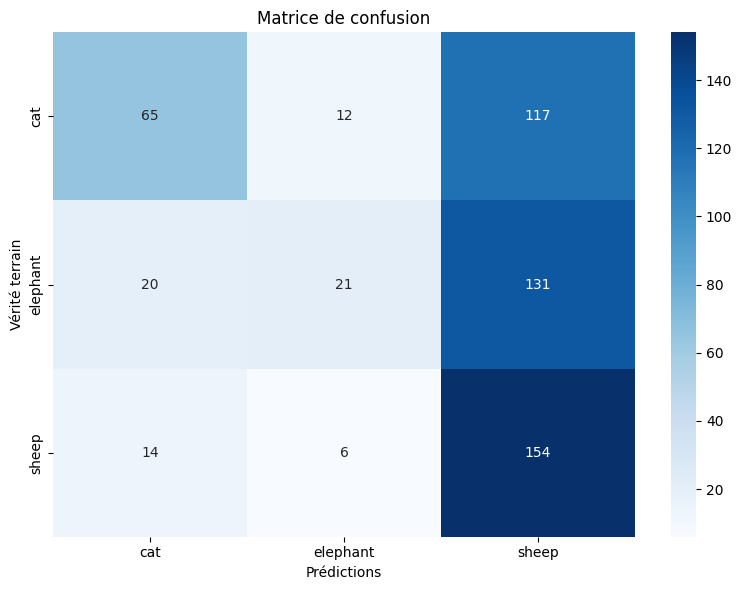

In [13]:
# Chargement du modèle sauvegardé
model_filename = "something.keras"
model_path = os.path.join('./data/dataset/Data_sheep_cat_elephant_with_caption_600', model_filename)
model = load_model(model_path)

# Prédiction
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Conversion de y_test
y_true_labels = np.argmax(y_test, axis=1)

# Matrice de confusion
conf = confusion_matrix(y_true_labels, y_pred_labels)


# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matrice de confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérité terrain")
plt.tight_layout()
plt.show()